In [2]:
# If an import error occurs try: 
# "pip install attrs==19.1.0" in the cmd
from pathlib import Path
import numpy as np
import pylab as pl
from numpy.testing.decorators import skipif
import mvpa2.suite as mvpa
from mvpa2.measures import rsa
import utility_functions as uf

In [3]:
# Wider Output
np.set_printoptions(edgeitems=20)

# Project Directory
project_dir = Path.cwd().parents[0]

# BOLD Files Directory
data_dir = project_dir.joinpath("data", "studyforrest-data-aligned")
if data_dir.is_dir():
    print("BOLD files directory found: \n {}\n".format(data_dir))
else:
    print("There is something wrong with the folder structure of the BOLD files\n")

# Anno Files Directory
anno_dir = project_dir.joinpath("data", "studyforrest-data-annotations")
if anno_dir.is_dir():
    print("Annotation files directory found: \n {}\n".format(anno_dir))
else:
    print("There is something wrong with the folder structure of the annotation files\n")

# Template Directory
template_dir = project_dir.joinpath("data", "studyforrest-data-templatetransforms")
if template_dir.is_dir():
    print("Template files directory found: \n {}\n".format(template_dir))
else:
    print("There is something wrong with the folder structure of the template files\n")

BOLD files directory found: 
 /home/arkani/Desktop/studyforrest_speaker_recognition/data/studyforrest-data-aligned

Annotation files directory found: 
 /home/arkani/Desktop/studyforrest_speaker_recognition/data/studyforrest-data-annotations

Template files directory found: 
 /home/arkani/Desktop/studyforrest_speaker_recognition/data/studyforrest-data-templatetransforms



In [4]:
# Get Participant Files
ao_files = uf.get_files(data_dir, '*aomovie*nii.gz')
av_files = uf.get_files(data_dir, '*avmovie*nii.gz')

# Get Annotation Files
ao_anno_files = uf.get_files(anno_dir, '*emotions*ao*run*.tsv')
av_anno_files = uf.get_files(anno_dir, '*emotions*av*run*.tsv')

# Get Warp Files
ref = str(template_dir.joinpath("templates", "grpbold3Tp2", "brain.nii.gz"))
warp_files = uf.get_files(template_dir, '*subj2tmpl_warp*.nii.gz')

# Check if all participant files are available
if (len(ao_files) == 112 and len(av_files) == 120):
    print("BOLD files availability test: \n all Bold files are available\n")
elif (len(ao_files) != 112 or len(av_files) != 120):
    if (len(ao_files) != 112):
        print("""BOLD files availability test:
              you are missing BOLD Files of the AO-movie runs\n""")
    elif (len(av_files) != 120):
        print("""BOLD files availability test:
              you are missing BOLD files of the AV-movie runs\n""")

# Check if all annotation files are available
if (len(ao_anno_files) == 8 and len(av_anno_files) == 8):
    print("Annotation files availability test: \n all Annotation files are available\n")
elif (len(ao_anno_files) != 8 or len(av_anno_files) != 8):
    if (len(ao_anno_files) != 8):
        print("""Annotation files availability test:
        you are missing annotation files of the AO-movie runs\n""")
    elif (len(av_anno_files) != 8):
        print("""Annotation files availability test:
        you are missing annotation files of the AV-movie runs\n""")

# Check if all warp files are available
if (len(warp_files)) == 15:
    print("Warp files availability test: \n all warp files are available\n")
else:
    print("""Annotation files availability test: \nyou are missing warp files\n""")

BOLD files availability test: 
 all Bold files are available

Annotation files availability test: 
 all Annotation files are available

Warp files availability test: 
 all warp files are available



In [6]:
## Prepare Dataset (raw Signal)
mask = str(project_dir.joinpath("data", "speakers_association-test_z_FDR_0.01.nii.gz"))
# targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'FORRESTJR', 'BUBBA', 'DAN', 'JENNY']
targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'JENNY']

ds = uf.preprocess_datasets(av_files[0:2], ref_space=ref, warp_files=warp_files, mask=mask, 
                            detrending=True, use_zscore=True, use_events=True, anno_dir=anno_dir, 
                            use_glm_estimates=False, targets=targets, event_offset=2, event_dur=6)

print("This is the shape of the dataset that will be used in the following Analysis: {}\n".format(ds.shape))

print("Used mask file: \n{}\n".format(mask))

all_events = ds.sa.targets
unique_events = np.unique(all_events)
num_events = len(ds.sa.targets)

print("The following unique events will be included: {}".format(unique_events))
print("The number of included events amounts to: {}\n".format(num_events))

print(ds.a)
print(ds.fa)
print(ds.sa)

This is the shape of the dataset that will be used in the following Analysis: (268, 4840)

Used mask file: 
/home/arkani/Desktop/studyforrest_speaker_recognition/data/speakers_association-test_z_FDR_0.01.nii.gz

The following unique events will be included: ['FORREST' 'FORRESTVO' 'JENNY' 'MRSGUMP']
The number of included events amounts to: 268

<DatasetAttributesCollection: imgaffine,imgtype,voxel_dim,voxel_eldim>
<FeatureAttributesCollection: event_offsetidx,voxel_indices>
<SampleAttributesCollection: chunks,duration,event_onsetidx,onset,orig_duration,orig_offset,orig_onset,participant,targets,time_coords,time_indices>


In [ ]:
# Save Dataset
ds_save_p = project_dir.joinpath("data", "tmp", "preprocessed_ds.hdf5")
if os.path.isfile(str(ds_save_p)):
    ds = h5load(ds_save_p)
else:
    h5save(ds_save_p, ds, compression=9)

In [10]:
# Normal Classifier Analysis
clf = mvpa.kNN(k=1, dfx=mvpa.one_minus_correlation, voting='majority')
clf.train(ds)
predictions = clf.predict(ds.samples)
print(np.mean(predictions == ds.sa.targets))

0.9253731343283582


This is the shape of the dataset that will be used in the following Analysis: (268, 4840)

Used mask file: 
/home/arkani/Desktop/studyforrest_speaker_recognition/data/speakers_association-test_z_FDR_0.01.nii.gz

The following unique events will be included: ['FORREST' 'FORRESTVO' 'JENNY' 'MRSGUMP']
The number of included events amounts to: 268

<DatasetAttributesCollection: imgaffine,imgtype,voxel_dim,voxel_eldim>
<FeatureAttributesCollection: event_offsetidx,voxel_indices>
<SampleAttributesCollection: chunks,duration,event_onsetidx,onset,orig_duration,orig_offset,orig_onset,participant,targets,time_coords,time_indices>


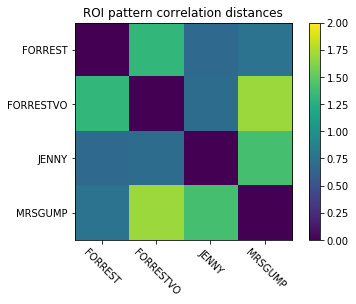

In [38]:
# RSA
mtgs = mvpa.mean_group_sample(['targets'])
mtds = mtgs(ds)
dsm = rsa.PDist(square=True)
res = dsm(mtds)

## Graphical Results
def plot_mtx(mtx, labels, title):
    pl.figure()
    pl.imshow(mtx, interpolation='nearest')
    pl.xticks(range(len(mtx)), labels, rotation=-45)
    pl.yticks(range(len(mtx)), labels)
    pl.title(title)
    pl.clim((0, 2))
    pl.colorbar()

plot_mtx(res, mtds.sa.targets, 'ROI pattern correlation distances')
pl.show()

In [9]:
## MVPA (GLM Estimates)
    # useful when: multiple concurrent signals are overlapping in time, such as in 
    # fast event-related designs
    # GLM estimates instead of raw data

# only 1 ds as input possible otherwise unstackable
# modify event dicts and stack datasets before event detection to make this work?
    
# Create Datset
mask_files = uf.get_files(project_dir, '*association*.nii.gz')
mask = mask_files[0]
# targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'FORRESTJR', 'BUBBA', 'DAN', 'JENNY']
# vstack Probleme wenn nicht in allen Runs die gleichen Targets gefunden werden?
targets = ['FORREST', 'MRSGUMP', 'FORRESTVO', 'FORRESTJR', 'DAN', 'JENNY']
ds = uf.preprocess_datasets(av_files[0], ref_space=ref, warp_files=warp_files, 
                            mask=mask, detrending=True, use_zscore=True, 
                            use_events=True, anno_dir=anno_dir, use_glm_estimates=True,
                            targets=targets, event_offset=2, event_dur=6)

print("This is the Dataset that will be used in the following Analysis:")
print("{}\n".format(ds))

print("Used mask file: \n{}\n".format(mask))
print(ds.sa)
print(ds.fa)
print(ds.a)

print("\nGLM Estimates were computed for the following targets: {}\n".format(ds.sa.targets))

# cross-validation Analysis with a chosen Classifier
clf = mvpa.kNN(k=1, dfx=mvpa.one_minus_correlation, voting='majority')
cv = mvpa.CrossValidation(clf, mvpa.NFoldPartitioner(attr='chunks'))
# cv_glm = cv(ds)
# print('%.2f' % np.mean(cv_glm))

This is the Dataset that will be used in the following Analysis:
<Dataset: 4x166148@float64, <sa: regressors,targets>, <fa: voxel_indices>, <a: add_regs,imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>>

Used mask file: 
/home/arkani/Desktop/studyforrest_speaker_recognition/data/speakers_association-test_z_FDR_0.01.nii.gz

<SampleAttributesCollection: regressors,targets>
<FeatureAttributesCollection: voxel_indices>
<DatasetAttributesCollection: add_regs,imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>

GLM Estimates were computed for the following targets: ['FORREST' 'FORRESTVO' 'JENNY' 'MRSGUMP']



In [ ]:
# kürzere code lines (pylint)

# vstack Probleme
    # glm estimates erzeugen Problem
    
# mask
    # restrict mask to ROIs
    # nilearn Methode: another Mask, Überschneidung, dann Dilatation
    # wie Info aus Atlanten verwenden? 
        # ROI representations in xml files (Bsp.: "/usr/share/data/mni-structural-atlas/MNI.xml")
            # Definition des ROIs für MNI 1mm
            # wie ROI Info anpassen an Grp Space

# Tests
    # Regression Tests: 
        # 1. finaler Code: Ergebnis speichern, 
        # nach Code Änderungen gucken, ob das gleiche rauskommt
        # über mvpa.seed Zufallswert festlegen, sonst entstehen 
        # jedes mal andere Ergebnisse
    # Unit tests
        # gucken ob output in richtiger relation zu input
        # zb gleiche m x n konfusionsmatrix
    # Datenintegritätschecks
        # für argument x wirklich eine Liste / str angegeben
    
# Vorgehensweise
    # jeden einzelnen Run mit dem jeweiligen Template für die VP in den Gruppenspace
        # sind momentan alle nur innerhalb der VP aligned
    # Maske an Gruppenraum anpassen
    # Maske bearbeiten (nur Sprachareale)